# Relax TakeHome Data Challenge

This challenge ought to be pretty short. My goal is to spend less than 3 hours on it. We have two .csv files;

* **takehome_users.csv** is a table with data on 12,000 users who joined over the course of approximately 2 years

* **takehome_user_engagement.csv** contains data about those users' engagement with the app

What we want to do is pretty simple also...

1. **Define *adopted* users**
    * A person is an adopted user if they use the app more than 3 times in any 7-day period
    
2. **Determine which factors predict user adoption**
    * First instinct is to use a random forest to determine feature importance
    * Second instinct is to use a linear model and classical statistical techniques and experimental design to determine the random effects of each feature
    
Let's just jump in.

In [1]:
# time is 4:47 on 2021-04-05

## Import Anticipated Packages

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

## Import and Clean Data

In [3]:
users = pd.read_csv('takehome_users.csv')
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


Quick word about each column:

* `object_id` - corresponds with `user_id` in the other DataFrame

* `creation_time` - Is it even possible that this matters? Let's think intuitively... Maybe people who sign up in the middle of the night are more desperate, and therefore more/less likely to be active users. Maybe there was something important going on in a specific month or on a specific day that made people likely to use the app and stick with it. Consider changing to separate `month` and `year` columns, or perhaps `month_year` or similar to look for patterns in this one.

* `name` - Probably drop. Only thing I can think of is that maybe we could use this to sort by race or gender and look for patterns that way. Would consider it in a deep analysis; not worth the time and effort in this challenge.

* `email` - Probably drop. Could perhaps use suffix (e.g. "gmail.com") to predict age (who uses hotmail any more?) or create a binary column of people who use work-emails to create their account.

* `creation_source` - Has 5 classes; One-Hot Encode this one

* `last_session_creation_time` - Need to change to interpretable datetime object. Seems unrelated to our definition of ***adopted user***.

* `opted_in_to_mailing_list` - Already binary. No need to change this one.

* `enabled_for_marketing_drip` - Already binary. No need to change this one, either.

* `org_id` - Could be important. This one is classes, not numeric. But it looks like there are many classes, so One-Hot Encoding may create too many features. Try one-hot; if it doesn't work, look into other ways to encode this one.

* `invited_by_user_id` - This one could be cool. First thought, create a binary column that defines whether a user `was_invited`. Next thought, find out if the user by which the current one was invited is an ***adopted user***. There could be scads of good information hidden in this feature.

In [4]:
engagement = pd.read_csv('takehome_user_engagement.csv')
engagement

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


Columns in the `engagement` DataFrame:

* `time_stamp` - The time when the user logged on. We will use this columns to form a rolling 7-day window and count the number of times in that window that each user logged on, and if that number is ever more than 3, we will say that the user is an ***adopted user***.

* `user_id` - Unique user id; corresponds to `object_id` in the other DataFrame.

* `visited` - This column is all ones. Just sum these up in each 7-day window.

In [5]:
engagement['visited'].unique()

array([1], dtype=int64)

## Create Target Column

The target will be called `adopted`, and will go in the `users` DataFrame. To make it, we need to... 

1.  Use the `engagement` DataFrame to
    1. Grab just the day from the `time_stamp` columns
    2. Group by date and by user
    3. Create a 7-day rolling window 
    4. Sum the logins of each user within that time-frame 
    5. Find which users have logged on at least 3 times in any 7-day period

2. Use the `users` DataFrame to
    1. Make an `adopted` column that is `1` when the user has logged on at least 3 times in any 7-day period and `0` otherwise

In [6]:
engagement.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [7]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
date_series = engagement['time_stamp'].copy()
for i, date in enumerate(date_series):
    date_series[i] = date.date()

In [8]:
engagement['day'] = date_series
engagement.drop('time_stamp', axis=1, inplace=True)

In [9]:
engagement = engagement.sort_values('day').reset_index(drop=True)

In [10]:
engagement

,user_id,visited,day
0,1693,1,2012-05-31
1,3428,1,2012-05-31
2,10012,1,2012-05-31
3,9899,1,2012-05-31
4,10163,1,2012-06-01
...,...,...,...
207912,3869,1,2014-06-04
207913,9968,1,2014-06-04
207914,203,1,2014-06-04
207915,7511,1,2014-06-04


In [31]:
users_grouped = engagement.groupby(['user_id', 'day']).count()
users_grouped

visited
user_id day                
1       2014-04-22        1
2       2013-11-15        1
        2013-11-29        1
        2013-12-09        1
        2013-12-25        1
...                     ...
11996   2013-09-06        1
11997   2013-01-15        1
11998   2014-04-27        1
11999   2012-06-02        1
12000   2014-01-26        1

[207917 rows x 1 columns]

In [75]:
ee = users_grouped.loc[[2],:]
ee.index = ee.index.droplevel()
ee.index = pd.to_datetime(ee.index)
ee = ee.resample('1D').count()
ee_sum = ee.rolling(7).sum()
ee_sum[ee_sum['visited'] >= 3]

,visited
day,
2014-02-09,3.0
2014-02-13,3.0
2014-02-14,3.0


In [96]:
adopted = pd.Series(index=users_grouped.index.get_level_values(0).unique())

<ipython-input-96-89c8231d08bb>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  adopted = pd.Series(index=users_grouped.index.get_level_values(0).unique())


In [98]:
for user_id in users_grouped.index.get_level_values(0).unique():
    user_frame = users_grouped.loc[[user_id], :]
    user_frame.index = user_frame.index.droplevel()
    
    if len(user_frame) < 3:
        adopted[user_id] = 0
    
    else:
        user_frame.index = pd.to_datetime(user_frame.index)
        user_frame = user_frame.resample('1D').count()
        user_sum = user_frame.rolling(7).sum()
        if user_sum.max()[0] >= 3:
            adopted[user_id] = 1
        else:
            adopted[user_id] = 0


In [114]:
adopted.name = 'adopted'

In [243]:
model_data = users.merge(adopted, left_on=users['object_id'], right_on=adopted.index, how='outer')
model_data.isna().sum()

key_0                            0
object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted                       3177
dtype: int64

In [244]:
model_data.head()

,key_0,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


## Feature Engineering

We can use the notes from when I first looked at the `users` DataFrame to help guide this part. Let's do this in stages.

#### Drop `key_0` and `name`

In [245]:
model_data = model_data.drop(['key_0', 'name'], axis=1)

#### Change `object_id` to `user_id`

In [246]:
model_data.columns = ['user_id'] + list(model_data.columns[1:])
model_data.head()

,user_id,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


#### Change `creation_time` to `creation_year`, `creation_month`, and `creation_day`

In [247]:
model_data['creation_time'] = pd.to_datetime(model_data['creation_time'])
model_data['creation_year'] = 0
model_data['creation_month'] = 0
model_data['creation_day'] = 0

for i, date in enumerate(model_data['creation_time']):
    model_data.loc[i, 'creation_year'] = date.year
    model_data.loc[i, 'creation_month'] = date.month
    model_data.loc[i, 'creation_day'] = date.day

#### One-Hot Encode creation_source

In [248]:
sources = model_data['creation_source'].unique()
for source in sources:
    model_data[source] = (model_data['creation_source'] == source) * 1

In [249]:
# now we can drop the `creation_source` column
model_data.drop('creation_source', axis=1, inplace=True)
model_data.head()

,user_id,creation_time,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_year,creation_month,creation_day,GUEST_INVITE,ORG_INVITE,SIGNUP,PERSONAL_PROJECTS,SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,0.0,2014,4,22,1,0,0,0,0
1,2,2013-11-15 03:45:04,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316.0,1.0,2013,11,15,0,1,0,0,0
2,3,2013-03-19 23:14:52,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,1525.0,0.0,2013,3,19,0,1,0,0,0
3,4,2013-05-21 08:09:28,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,5151.0,0.0,2013,5,21,1,0,0,0,0
4,5,2013-01-17 10:14:20,GraceRaw@yahoo.com,1.358850e+09,0,0,193,5240.0,0.0,2013,1,17,1,0,0,0,0


#### Grab `email` suffix, then One-Hot Encode

In [250]:
for i in range(len(model_data['email'])):
    model_data.loc[i, 'email'] = model_data.loc[i, 'email'].split('@')[1]

In [251]:
emails = model_data['email'].unique()[(model_data['email'].value_counts() > 500)]
for email in emails:
    model_data[email] = (model_data['email'] == email) * 1

In [252]:
model_data.drop('email', axis=1, inplace=True)
model_data.head()

,user_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_year,creation_month,...,ORG_INVITE,SIGNUP,PERSONAL_PROJECTS,SIGNUP_GOOGLE_AUTH,yahoo.com,gustr.com,jourrapide.com,hotmail.com,cuvox.de,gmail.com
0,1,2014-04-22 03:53:30,1.398139e+09,1,0,11,10803.0,0.0,2014,4,...,0,0,0,0,1,0,0,0,0,0
1,2,2013-11-15 03:45:04,1.396238e+09,0,0,1,316.0,1.0,2013,11,...,1,0,0,0,0,1,0,0,0,0
2,3,2013-03-19 23:14:52,1.363735e+09,0,0,94,1525.0,0.0,2013,3,...,1,0,0,0,0,1,0,0,0,0
3,4,2013-05-21 08:09:28,1.369210e+09,0,0,1,5151.0,0.0,2013,5,...,0,0,0,0,1,0,0,0,0,0
4,5,2013-01-17 10:14:20,1.358850e+09,0,0,193,5240.0,0.0,2013,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,1.378448e+09,0,0,89,8263.0,0.0,2013,9,...,1,0,0,0,0,1,0,0,0,0
11996,11997,2013-01-10 18:28:37,1.358275e+09,0,0,200,NaN,0.0,2013,1,...,0,0,0,1,0,0,0,0,0,1
11997,11998,2014-04-27 12:45:16,1.398603e+09,1,1,83,8074.0,0.0,2014,4,...,0,0,0,0,0,0,0,0,1,0
11998,11999,2012-05-31 11:55:59,1.338638e+09,0,0,6,NaN,0.0,2012,5,...,0,0,1,0,0,0,0,0,0,0


#### Change `last_session_creation_time` to datetime

In [253]:
dt.datetime.fromtimestamp(model_data.loc[0, 'last_session_creation_time'])

datetime.datetime(2014, 4, 21, 22, 53, 30)

In [254]:
for i in range(len(model_data['last_session_creation_time'])):
    if np.isnan(model_data.loc[i, 'last_session_creation_time']):
        continue
    else:
        model_data.loc[i, 'last_session_creation_time'] = dt.datetime.fromtimestamp(model_data.loc[i, 'last_session_creation_time'])

#### Find number of days between `creation_time` and `last_session_creation_time`

In [266]:
model_data['last_session_creation_time'] = pd.to_datetime(model_data['last_session_creation_time'])
model_data['time_used'] = model_data['last_session_creation_time'] - model_data['creation_time']
model_data['time_used'] = model_data['time_used'].round('1D')

In [270]:
# drop the `creation_time` column
model_data.drop('creation_time', axis=1, inplace=True)
model_data.drop('last_session_creation_time', axis=1, inplace=True)

In [277]:
for t in range(len(model_data['time_used'])):
    model_data.loc[t, 'time_used'] = model_data.loc[t, 'time_used'].days

In [278]:
model_data

,user_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_year,creation_month,creation_day,GUEST_INVITE,...,SIGNUP,PERSONAL_PROJECTS,SIGNUP_GOOGLE_AUTH,yahoo.com,gustr.com,jourrapide.com,hotmail.com,cuvox.de,gmail.com,time_used
0,1,1,0,11,10803.0,0.0,2014,4,22,1,...,0,0,0,1,0,0,0,0,0,0
1,2,0,0,1,316.0,1.0,2013,11,15,0,...,0,0,0,0,1,0,0,0,0,136
2,3,0,0,94,1525.0,0.0,2013,3,19,0,...,0,0,0,0,1,0,0,0,0,0
3,4,0,0,1,5151.0,0.0,2013,5,21,1,...,0,0,0,1,0,0,0,0,0,1
4,5,0,0,193,5240.0,0.0,2013,1,17,1,...,0,0,0,1,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,0,0,89,8263.0,0.0,2013,9,6,0,...,0,0,0,0,1,0,0,0,0,0
11996,11997,0,0,200,NaN,0.0,2013,1,10,0,...,0,0,1,0,0,0,0,0,1,5
11997,11998,1,1,83,8074.0,0.0,2014,4,27,1,...,0,0,0,0,0,0,0,1,0,0
11998,11999,0,0,6,NaN,0.0,2012,5,31,0,...,0,1,0,0,0,0,0,0,0,2


#### One-Hot Encode large `org_id`

In [282]:
large_orgs = model_data['org_id'].unique()[model_data['org_id'].value_counts() > 100]
for org in large_orgs:
    model_data['orgnum_' + str(org)] = (model_data['org_id'] == org)*1

In [284]:
# drop `org_id`
model_data.drop('org_id', axis=1, inplace=True)
model_data.head()

,user_id,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,adopted,creation_year,creation_month,creation_day,GUEST_INVITE,ORG_INVITE,...,orgnum_11,orgnum_1,orgnum_94,orgnum_193,orgnum_197,orgnum_37,orgnum_74,orgnum_302,orgnum_318,orgnum_69
0,1,1,0,10803.0,0.0,2014,4,22,1,0,...,1,0,0,0,0,0,0,0,0,0
1,2,0,0,316.0,1.0,2013,11,15,0,1,...,0,1,0,0,0,0,0,0,0,0
2,3,0,0,1525.0,0.0,2013,3,19,0,1,...,0,0,1,0,0,0,0,0,0,0
3,4,0,0,5151.0,0.0,2013,5,21,1,0,...,0,1,0,0,0,0,0,0,0,0
4,5,0,0,5240.0,0.0,2013,1,17,1,0,...,0,0,0,1,0,0,0,0,0,0


#### Create `was_invited` column

In [288]:
model_data['was_invited'] = (model_data['invited_by_user_id'].isna())*1
model_data.drop('invited_by_user_id', axis=1, inplace=True)
model_data.head()

,user_id,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,creation_year,creation_month,creation_day,GUEST_INVITE,ORG_INVITE,SIGNUP,...,orgnum_1,orgnum_94,orgnum_193,orgnum_197,orgnum_37,orgnum_74,orgnum_302,orgnum_318,orgnum_69,was_invited
0,1,1,0,0.0,2014,4,22,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,1.0,2013,11,15,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,3,0,0,0.0,2013,3,19,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,4,0,0,0.0,2013,5,21,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5,0,0,0.0,2013,1,17,1,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,0,0,0.0,2013,9,6,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11996,11997,0,0,0.0,2013,1,10,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11997,11998,1,1,0.0,2014,4,27,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11998,11999,0,0,0.0,2012,5,31,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Decide what to do with missing values

Random Forests can handle missing values with no problem, so maybe we need not do anything. However, I was going to use a RidgeClassifier as well, to check out the direction of the relationship between features and adoption, so I do need to think about how to handle missing values.

In [292]:
model_data.isna().sum().sort_values(ascending=False).head()

adopted      3177
time_used    3177
user_id         0
cuvox.de        0
orgnum_69       0
dtype: int64

All of the missing values are in the `time_used` and `adopted` columns. Random Forest can't handle that. There are 3,177 missing values, out of a total of 12,000. If we just drop the observations with missing values, we will still have 8,823 observations. That should be plenty of data. So let's just drop rows with missing values.

In [302]:
model_data.dropna(inplace=True)
model_data['adopted'] = model_data['adopted'].astype(int)
model_data['time_used'] = model_data['time_used'].astype(int)
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   user_id                     8823 non-null   int64
 1   opted_in_to_mailing_list    8823 non-null   int64
 2   enabled_for_marketing_drip  8823 non-null   int64
 3   adopted                     8823 non-null   int32
 4   creation_year               8823 non-null   int64
 5   creation_month              8823 non-null   int64
 6   creation_day                8823 non-null   int64
 7   GUEST_INVITE                8823 non-null   int32
 8   ORG_INVITE                  8823 non-null   int32
 9   SIGNUP                      8823 non-null   int32
 10  PERSONAL_PROJECTS           8823 non-null   int32
 11  SIGNUP_GOOGLE_AUTH          8823 non-null   int32
 12  yahoo.com                   8823 non-null   int32
 13  gustr.com                   8823 non-null   int32
 14  jourrap

## Correlation in Features

Normally, I would want to check the features for multicollinearity, or high correlation, because many model types (such as the RangeClassifier I place to use later) do not handle correlated features very well. However, **none** of the feature we are going to use are numeric. They are all factors, integers, or classes. This makes correlation a problematic desriptor of the relationship between features.

However, it is highly likely that some of our factors are related, such as `SIGNUP_GOOGLE_AUTH` and using a `gmail.com` account. But let's not worry too about that right now. This will do fine for the analysis at hand.

## Random Forest

A benefit of using this random forest model is that it naturally supplies a measure of feature importance. Great!

We will use the Recall metric, also known as the True Positive Rate, to evaluate the model. Recall measures the proportion of real positives that are found by the model. In this use case, the most important thing for the model is to find all of the users who became ***adopted users***, and Recall measures how many of those adopted users the model finds. Then, we can check *why* the model predicts that they were adopted.

In [304]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [319]:
model = RandomForestClassifier()

# param_grid was reshaped to a finer mesh several times, yielding the best-performing hyperparameters
param_grid = {'n_estimators':np.arange(100, 300, 50),
              'criterion':['gini'],
              'min_samples_split':np.arange(8, 12, 1)}

model_cv = GridSearchCV(model, param_grid=param_grid, scoring='recall', cv=5)

In [320]:
X = model_data.drop(['adopted', 'user_id'], axis=1)
y = model_data['adopted']

In [321]:
model_cv.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'],
                         'min_samples_split': array([ 8,  9, 10, 11]),
                         'n_estimators': array([100, 150, 200, 250])},
             scoring='recall')

In [322]:
model_cv.best_score_

0.8810442789968652

In [323]:
model_cv.best_params_

{'criterion': 'gini', 'min_samples_split': 10, 'n_estimators': 100}

In [324]:
best_mod_refit = RandomForestClassifier(n_estimators=200, criterion = 'gini', min_samples_split=10)
best_mod_refit.fit(X, y)
best_pred = best_mod_refit.predict(X)
recall = recall_score(y, best_pred)
confmat = confusion_matrix(y, best_pred)

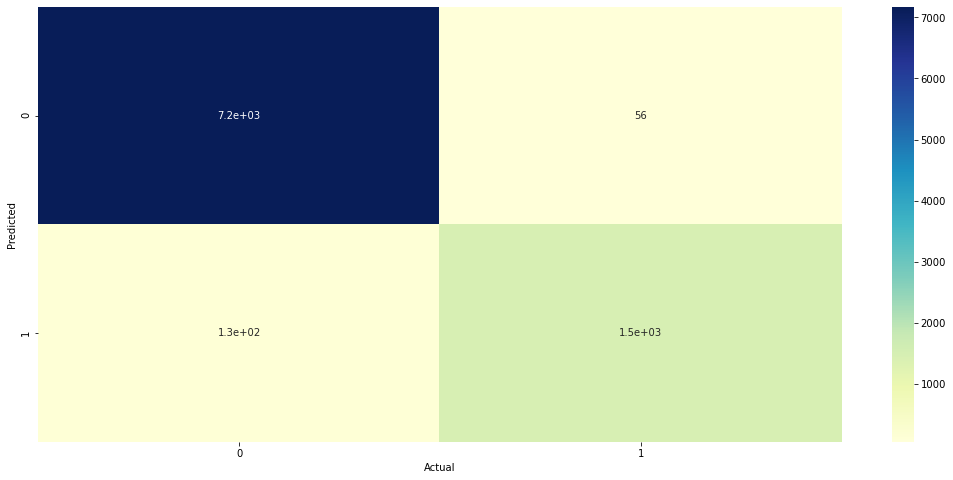

In [328]:
plt.figure(figsize=(18,8))
sns.heatmap(confmat, annot=True, cmap='YlGnBu')
plt.xlabel('Actual')
plt.ylabel('Predicted');

As shown in the confusion matrix,

In [330]:
print(classification_report(y, best_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7226
           1       0.96      0.92      0.94      1597

    accuracy                           0.98      8823
   macro avg       0.97      0.96      0.96      8823
weighted avg       0.98      0.98      0.98      8823



These metrics are pretty great across the board. Random Forest complete. Let's check the feature importance.

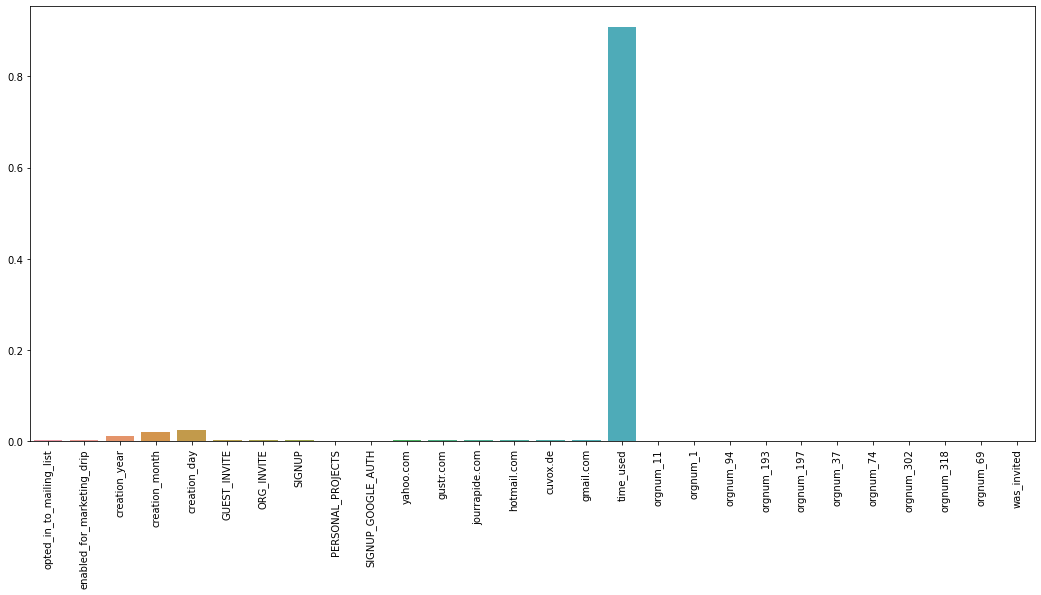

In [340]:
feat_imp = best_mod_refit.feature_importances_
plt.figure(figsize=(18,8))
sns.barplot(x=X.columns, y=feat_imp)
plt.xticks(rotation=90);

Wow. By far the biggest predictor of adoption is the length of time between account creation and the last time they logged in. People who use the app over a longer period of time are more likely to be adopted users. That makes so much sense that it feels like cheating. Let's fit the model again, but without using the `time_used` feature.

### Random Forest Revisited

In [341]:
X.drop('time_used', axis=1, inplace=True)

In [361]:
model = RandomForestClassifier()

param_grid = {'n_estimators':np.arange(150,300,25),
              'min_samples_split':[2]}

model_cv = GridSearchCV(model, param_grid=param_grid, scoring='recall', cv=5)

In [362]:
model_cv.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_split': [2],
                         'n_estimators': array([150, 175, 200, 225, 250, 275])},
             scoring='recall')

In [363]:
model_cv.best_score_

0.08452978056426333

In [364]:
best_forest = model_cv.best_estimator_
pred = best_forest.predict(X)
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7226
           1       0.96      0.84      0.90      1597

    accuracy                           0.96      8823
   macro avg       0.96      0.92      0.94      8823
weighted avg       0.96      0.96      0.96      8823



In [380]:
best_forest_refit = RandomForestClassifier(n_estimators=200, min_samples_split=2)
best_forest_refit.fit(X,y)
best_forest_refit_pred = best_forest_refit.predict(X)
print(classification_report(y, best_forest_refit_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7226
           1       0.97      0.83      0.90      1597

    accuracy                           0.96      8823
   macro avg       0.97      0.91      0.94      8823
weighted avg       0.97      0.96      0.96      8823



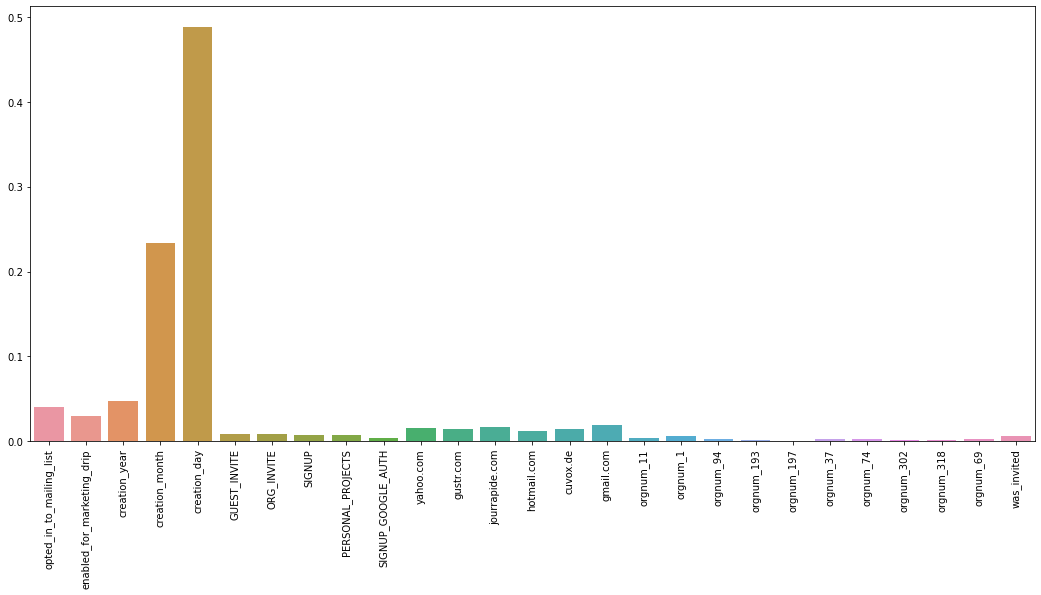

In [381]:
new_feat_imp = best_forest_refit.feature_importances_
plt.figure(figsize=(18,8))
sns.barplot(x=X.columns, y=new_feat_imp)
plt.xticks(rotation=90);

Well then. `creation_day`, which I thought about discarding, is apparently important. I wonder how that happened? I am worried that the time-based columns all correlate with `time_used`. Let's find out.

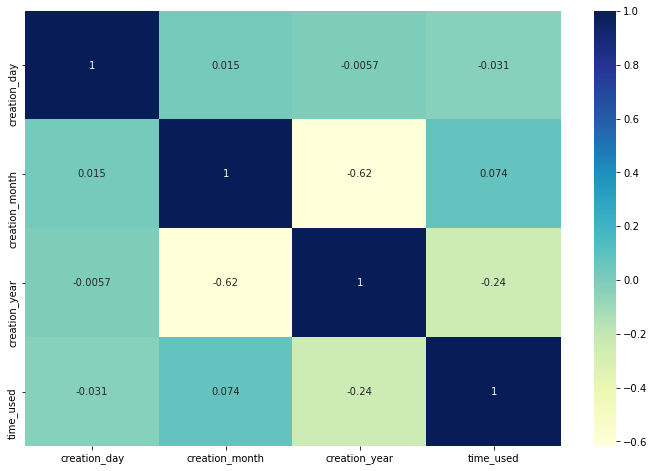

In [397]:
time_df = model_data[['creation_day', 'creation_month', 'creation_year', 'time_used']].copy()
time_cormat = time_df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(time_cormat, annot=True, cmap='YlGnBu');

Huh. They don't really. Maybe `creation_year` has a decent negative correlation, because earlier years give users more time to have spent using the app...but not a big correlation like I'd feared. I guess the day on which people create their account really is important to their adoption of the service...

One more thing before I am convince; I am going to separate the `creation_day` column into 3 bins:

* `beginning_of_month` when `creation_day` $\le$ 10
* `middle_of_month` when 10 $<$ `creation_day` $<$ 20
* `end_of_month` when 20 $\le$ `creation_day`

And then we will see if there is still a relationship.

In [400]:
X['beginning_of_month'] = (X['creation_day'] <= 10)*1
X['middle_of_month'] = ((X['creation_day'] > 10) & (X['creation_day'] < 20))*1
X['end_of_month'] = (X['creation_day'] >= 20)*1
X.drop('creation_day', axis=1, inplace=True)
X

,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_year,creation_month,GUEST_INVITE,ORG_INVITE,SIGNUP,PERSONAL_PROJECTS,SIGNUP_GOOGLE_AUTH,yahoo.com,...,orgnum_197,orgnum_37,orgnum_74,orgnum_302,orgnum_318,orgnum_69,was_invited,beginning_of_month,middle_of_month,end_of_month
0,1,0,2014,4,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,2013,11,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,2013,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,2013,5,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,2013,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0,0,2013,9,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11996,0,0,2013,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
11997,1,1,2014,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11998,0,0,2012,5,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [432]:
X['beginning_of_year'] = (X['creation_month'] <= 4)*1
X['middle_of_year'] = ((X['creation_month'] > 4) & (X['creation_month'] < 8))*1
X['end_of_year'] = (X['creation_month'] >= 8)*1
X.drop('creation_month', axis=1, inplace=True)
X

,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_year,GUEST_INVITE,ORG_INVITE,SIGNUP,PERSONAL_PROJECTS,SIGNUP_GOOGLE_AUTH,yahoo.com,gustr.com,...,orgnum_302,orgnum_318,orgnum_69,was_invited,beginning_of_month,middle_of_month,end_of_month,beginning_of_year,middle_of_year,end_of_year
0,1,0,2014,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
1,0,0,2013,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
2,0,0,2013,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
3,0,0,2013,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
4,0,0,2013,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0,0,2013,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
11996,0,0,2013,0,0,0,0,1,0,0,...,0,0,0,1,1,0,0,1,0,0
11997,1,1,2014,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
11998,0,0,2012,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,1,0


In [434]:
model = RandomForestClassifier()
model.fit(X, y)
model_pred = model.predict(X)
print(classification_report(y, model_pred))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      7226
           1       0.79      0.19      0.31      1597

    accuracy                           0.84      8823
   macro avg       0.82      0.59      0.61      8823
weighted avg       0.84      0.84      0.80      8823



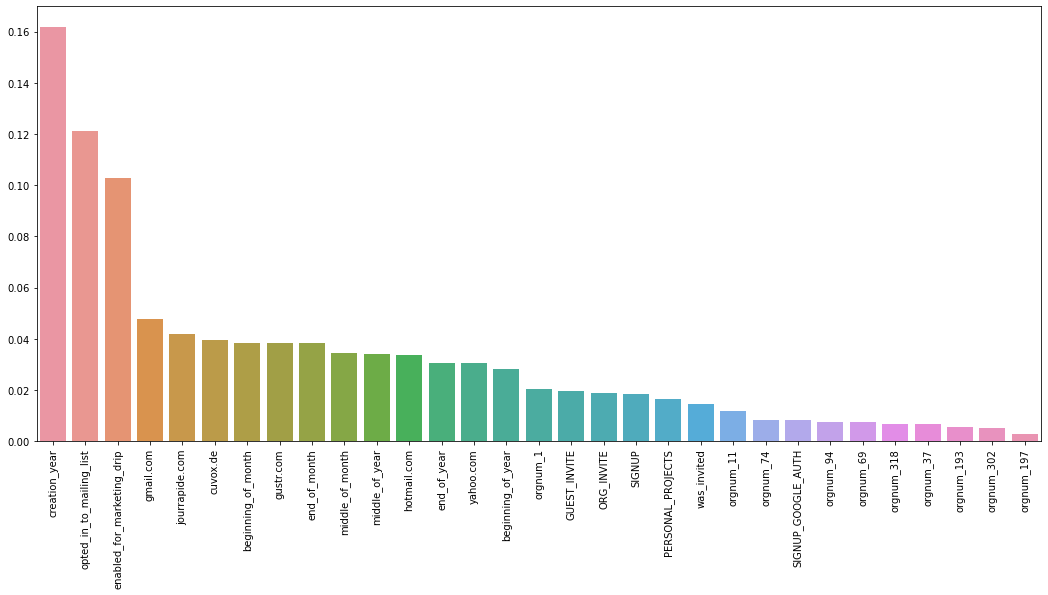

In [438]:
newest_feat_imp = pd.Series(model.feature_importances_, index=X.columns)
newest_feat_imp = newest_feat_imp.sort_values(ascending=False)
plt.figure(figsize=(18,8))
sns.barplot(x=newest_feat_imp.index, y=newest_feat_imp)
plt.xticks(rotation=90);

As we can see, the importance of a time-based column is divided when that column is binned. Lastly, let's drop `creation_year` entirely, as it is most closely related to the discarded `time_used` feature.

In [439]:
X.drop('creation_year', axis=1, inplace=True)

In [440]:
model = RandomForestClassifier()
model.fit(X, y)
model_pred = model.predict(X)
print(classification_report(y, model_pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      7226
           1       0.76      0.12      0.20      1597

    accuracy                           0.83      8823
   macro avg       0.80      0.55      0.55      8823
weighted avg       0.82      0.83      0.78      8823



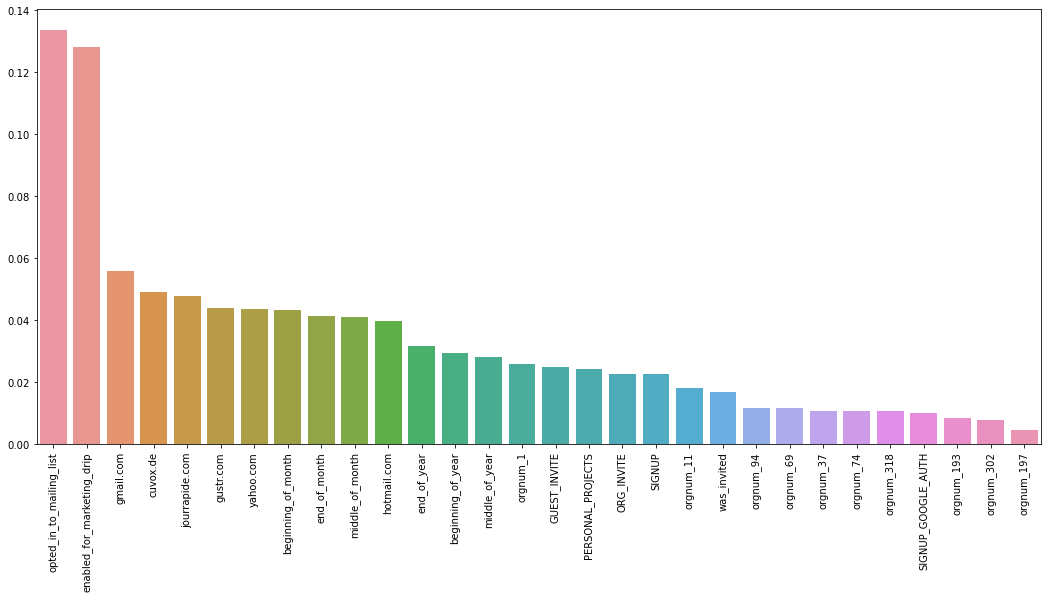

In [441]:
newest_feat_imp = pd.Series(model.feature_importances_, index=X.columns)
newest_feat_imp = newest_feat_imp.sort_values(ascending=False)
plt.figure(figsize=(18,8))
sns.barplot(x=newest_feat_imp.index, y=newest_feat_imp)
plt.xticks(rotation=90);

Now, these are some feature we can trust and perhaps directly influence! 

* The most important feature, according to this random forest, is `opted_in_to_mailing_list`, meaning the user received marketing emails. I guess those emails are working! We just need more people to receive them. 

* Second is `enabled_for_marketing_drip`, which means that the user is on the regular marketing drip, they receive regular marketing emails. Again, marketing seems to be working.

* Next, the different emails seem to be important. This will be explored more in the RidgeClassifier we are going to make shortly.

* Then, the part of the month in which a user creates their account. Again, this needs more clarification from the RidgeClassifier.

After that, the features drop off in importance. Interestingly, belonging to an in-app organization (`org_id`) was not important, and neither was `creation_source` (although there may be some overlap importance between using a `gmail.com` account and `SIGNUP_GOOGLE_AUTH`).

### Logistic Regression

This fits a logistic regression model to the data. We can use the coefficients of this regression to see which features have a positive relationship to adoption.

There might be a problem with imbalance in the dataset, so we will train the regression on a perfectly balanced dataset.

In [536]:
positives = model_data[model_data['adopted'] == 1]
negatives = model_data[model_data['adopted'] == 0]
negatives = negatives.sample(len(positives))
balanced_data = pd.concat([positives, negatives])

In [540]:
balanced_data = balanced_data.sample(frac=1)

In [541]:
X_balanced = X.loc[balanced_dataset.index, :]
y_balanced = y.loc[balanced_dataset.index]

In [542]:
from sklearn.linear_model import LogisticRegressionCV

In [543]:
logmod = LogisticRegressionCV(scoring='recall')
logmod.fit(X_balanced, y_balanced)
logmod_pred = logmod.predict(X)
print(classification_report(y, logmod_pred))

              precision    recall  f1-score   support

           0       0.86      0.57      0.68      7226
           1       0.22      0.56      0.32      1597

    accuracy                           0.57      8823
   macro avg       0.54      0.57      0.50      8823
weighted avg       0.74      0.57      0.62      8823



This model isn't great, but we just want the coefficient relationships, anyway.

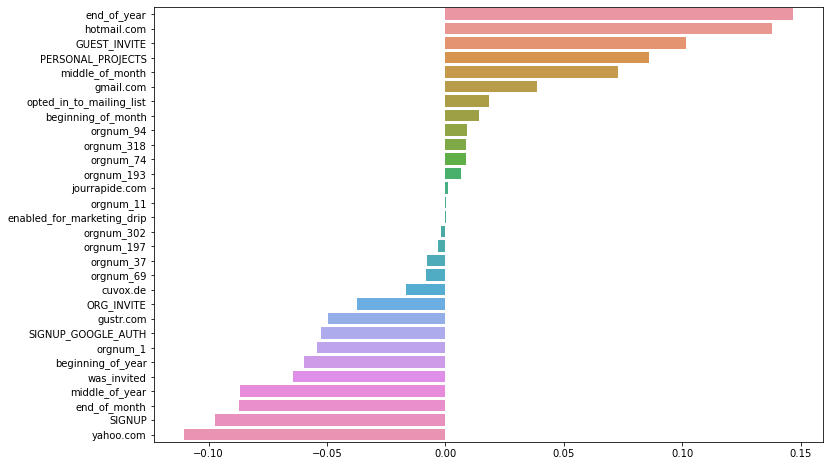

In [558]:
coef_df = pd.Series(logmod.coef_[0], index=X_balanced.columns)
coef_df = coef_df.sort_values(ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x=coef_df, y=coef_df.index);

In order of feature importance:

* `opted_in_to_mailing_list` - POSITIVE. People who opt in to the mailing list are more likely to adopt

* `enabled_for_marketing_drip` - NEAR ZERO. It is hard to say what effect this feature has on adoption

* `gmail.com` - POSITIVE. Gmail users are more likely to become adopted users.

* People using temporary email addresses, such as from `cuvox.de`, `gustr.com`, or `jourrapide.com` are less likely to adopt (or have a near-zero coefficient, like `jourrapide.com`).

* `yahoo.com` has a large negative coefficient; we should research more to see why yahoo users are so unlikely to adopt the service

* The time of the month in which people sign up seems to be important. We will definitely need to look deeper into this:
    * `middle_of_month`, between the 10th and the 20th, has a positive relationship with adoption
    * `beginning_of_month`, on the 10th and earlier, also has a positive effect on adoption
    * `end_of_month`, on the 20th and after, has a negative effect on adoption

* `hotmail.com` has a positive relationship with adoption. Perhaps because a lot of hotmail accounts are work-emails?

* The time of year in which people create their accounts has some effect on adoption. We need to look into this. Maybe new graduates, who get jobs a couple of months after graduation, are likely to become adopted users?
    * `end_of_year`, August or later, has a large positive coefficient
    * `beginning_of_year` and `middle_of_year` both have negative coefficients
    
There is plenty to explore in these results, and the rest of the features are relatively unimportant.